# Import and settings

In [84]:
import os
import anndata as ad
import warnings
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import sys
import re
import matplotlib.pyplot as plt
import scanpy.external as sce
import pandas as pd
import gc
import seaborn as sns
from scipy.sparse import issparse
from scipy.stats import spearmanr
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(10, 10))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [ ]:
def smooth(adata, num_nbrs=30, num_samples=10, xkey='x', ykey='y', num_drop=None,
           subsample=False, use_highly_variable=False, use_spatially_variable=False, sigma = None):

    # Find nbrhds
    coordinates = adata.obsm["spatial"]    
    nbrs = NearestNeighbors(n_neighbors=num_nbrs)
    nbrs.fit(coordinates)
    _, nbr_idxs = nbrs.kneighbors(coordinates)

    # Subsample nbrhds
    if num_drop:
        nbr_idxs_sampled = nbr_idxs[:,num_drop:]
    elif subsample:
        nbr_idxs_sampled = [np.random.choice(idxs, size=num_samples) for idxs in nbr_idxs]
    else:
        nbr_idxs_sampled = nbr_idxs

    # Isolate highly/spatially variable genes
    if use_highly_variable:
        X = adata.X[:, adata.var['highly_variable']]
    elif use_spatially_variable:
        X = adata.X[:, adata.var['spatially_variable']]
    else:
        #X = adata.obsm['scvi_CT_I']
        X = adata.obsm['X_pca']
    # Concatenate nbr vectors
    X_smooth = []
    for nth_nbrs in np.array(nbr_idxs_sampled).T:
        X_smooth.append(X[nth_nbrs])
    X_smooth = np.hstack(X_smooth)
    if sigma:
        X_smooth = gaussian_filter1d(X_smooth, sigma=sigma, axis=1)
    return X_smooth

# sFig2 B

## 1. qc

In [ ]:
id_list = ['A02382D1','A02384C3'，'A02384C4'，'FP200000373TR_A4','FP200000474BL_E4','FP200000442TL_A2']

In [ ]:
for id in id_list:
    adata = sc.read_h5ad(f'/home/share/project/stereoV2/02.basic_analysis/bin50/h5ad/{id}.h5ad.gz')
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=10)
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],save = f'{id}_qc.pdf',
                jitter=0.4, multi_panel=True)
    #sc.pp.normalize_total(adata, target_sum=1e4)
    #sc.pp.log1p(adata)
    #sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    #sc.pl.highly_variable_genes(adata,save = f'{id}_highly_variable_genes.pdf',)
    adata.obsm['spatial'] = pd.DataFrame(adata.obs.index.str.split('-').tolist()).values.astype('int')
    ### build image 
    image = np.zeros([650, 650, 3], np.uint8)
    spatial_key = "spatial"
    library_id = "0"
    adata.uns[spatial_key] = {library_id: {}}
    adata.uns[spatial_key][library_id]["images"] = {}
    adata.uns[spatial_key][library_id]["images"] = {"hires": image}
    adata.uns[spatial_key][library_id]["scalefactors"] = {"tissue_hires_scalef": 1, "spot_diameter_fullres": 1}
    sc.pl.spatial(adata, color='n_genes',size = 1,spot_size = 1,save = f'{id}_n_genes.pdf')
    adata.write_h5ad(f'{id}.h5ad.gz')
    adata.obs.to_csv(f'{id}_obs.csv')
    adata.var.to_csv(f'{id}_var.csv')

## 2. remove batch

id_list = ['A02382D1','A02384C3','A02384C4','FP200000373TR_A4','FP200000474BL_E4','FP200000442TL_A2']

In [ ]:
L = []
for id in id_list:
    adata = sc.read_h5ad(f'/home/share/project/stereoV2/02.basic_analysis//bin50/h5ad/{id}_raw.h5ad')
    adata.obs['chip'] = id
    adata.obs_names = id+'-'+adata.obs_names
    L.append(adata)

In [ ]:
all_adata = sc.concat(L,join = 'outer')

In [ ]:
#################################################################### SCVI ####################################################
condition_key = 'chip'

adata = sc.read_h5ad('/home/share/huadjyin/home/xiangrong1/project/stereoV2/02.basic_analysis/all_adata.h5ad.gz')

save_path = f'/home/share/project/stereoV2/03.remove_batch/'
ref_path = os.path.join(save_path,'ref_model')
if not os.path.exists(ref_path):
    os.makedirs(ref_path)

adata = remove_sparsity(adata)
#### train
sca.models.SCVI.setup_anndata(adata, batch_key=condition_key)
vae = sca.models.SCVI(
            adata,
            n_layers=2,
            n_latent = 15,
            #encode_covariates=True,
            #deeply_inject_covariates=False,
            use_layer_norm="both",
            use_batch_norm="none",
                                )
vae.train(max_epochs=100)
vae.save(ref_path, overwrite=True)
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs = adata.obs.copy()
## save SCVI
reference_latent.write_h5ad(f"{save_path}/scvi.h5ad"),


## 3. region

In [ ]:
os.chdir('/home/share/project/stereoV2/06.region/')
import scanpy as sc
import squidpy as sq
import os
import scanpy as sc
import random
random.seed(1)
import numpy as np
np.random.seed(1)
import anndata as ad
#import squidpy as sq
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import argparse
import os

In [ ]:
scvi = sc.read_h5ad("/home/share/project/stereoV2/03.remove_batch/scvi.h5ad")
adata.obsm['X_pca'] = scvi.X

image = np.ones([650, 650, 3], np.uint8) * 255
spatial_key = "spatial"
library_id = "0"
adata.uns[spatial_key] = {library_id: {}}
adata.uns[spatial_key][library_id]["images"] = {}
adata.uns[spatial_key][library_id]["images"] = {"hires": image}
adata.uns[spatial_key][library_id]["scalefactors"] = {"tissue_hires_scalef": 1, "spot_diameter_fullres": 1}

In [ ]:
xkey='x'
ykey='y'
num_pcs=10
svd_solver='randomized'
batch_key='sample'
num_drop=False
pca_key='X_pca_spin'
use_highly_variable=False
num_hvgs=None
subsample=True
use_spatially_variable=False
svg_method='moran'
num_genes=1000
xkey = 'x'
ykey = 'y'
region_key = "top_region_cluster"

num_nbrs=20
num_samples = 10
print(num_nbrs,num_samples)
X_smooth = []
X_smooth.append(smooth(adata,
           num_nbrs=num_nbrs,
           num_samples=num_samples,
           xkey=xkey,
           ykey=ykey,
           use_highly_variable=use_highly_variable,
           use_spatially_variable=use_spatially_variable,
           num_drop=num_drop,
           subsample=subsample
            ))
X_smooth = np.vstack(X_smooth)
pca = PCA(n_components=num_pcs, svd_solver=svd_solver)
adata.obsm[pca_key] = pca.fit_transform(X_smooth)

sc.pp.neighbors(adata, use_rep=pca_key, key_added=region_key)
sc.tl.leiden(adata, resolution = 2, key_added=region_key, neighbors_key=region_key)

In [ ]:
sc.pl.spatial(adata,color = region_key,spot_size = 1,size = 1,palette=sc.pl.palettes.default_102)

In [77]:
# adata=sc.read_h5ad('/home/lee/project/v2/mouse_brain/h5ads/mouse_brain_merge2.h5ad')
# adata

AnnData object with n_obs × n_vars = 224218 × 36803
    obs: 'orig.ident', 'x', 'y', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'leiden', 'res_0.8', 'res_1', 'res_1.2', 'res_1.5', 'res_2', 'chip', 'cell_type_I', 'region'
    uns: 'region_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_bak', 'spin'
    layers: 'count'

In [47]:
# region=pd.read_csv('/home/lixinxing/V2/diffusion/meta_region.csv',index_col=0)
# adata.obs = adata.obs.join(region[['top_region_cluster']])

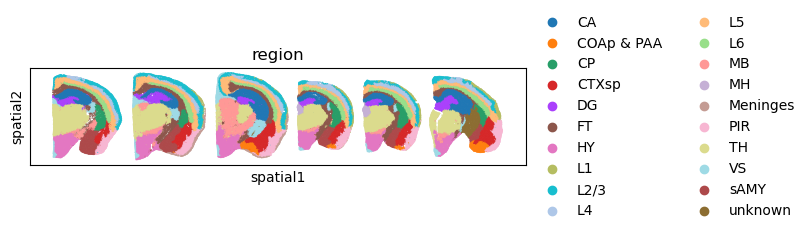

In [78]:
sc.pl.spatial(adata,color = 'region',spot_size = 100)

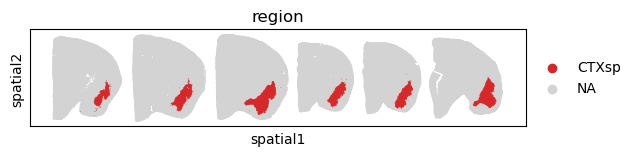

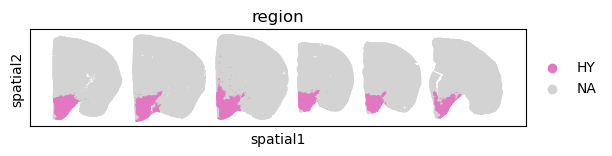

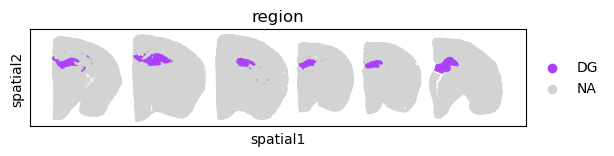

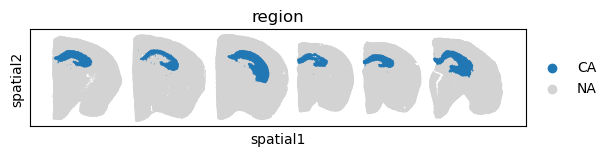

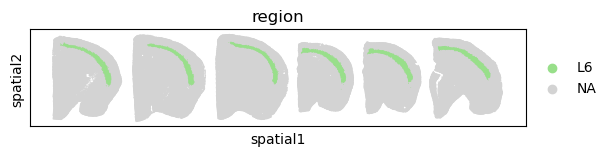

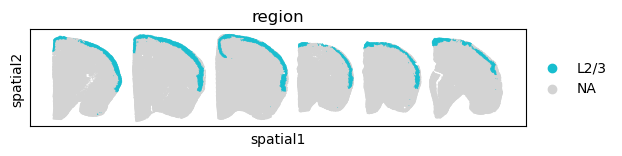

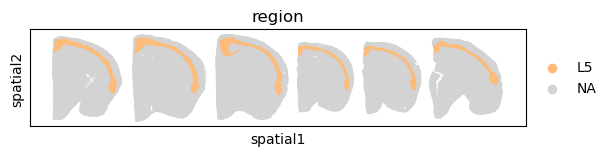

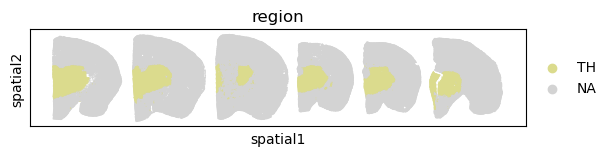

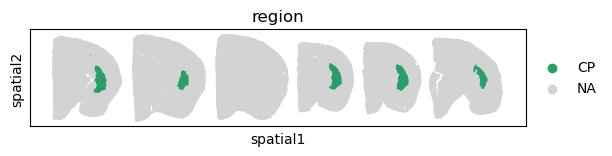

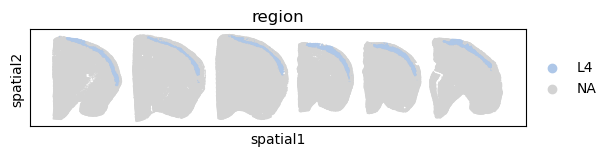

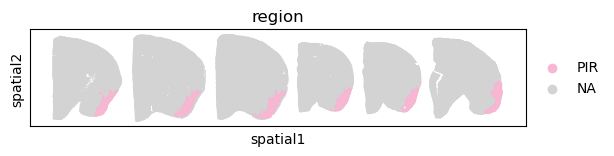

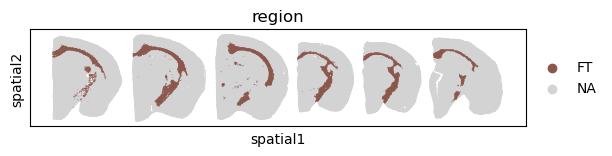

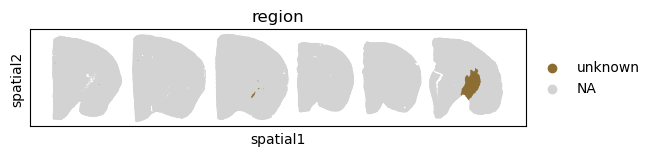

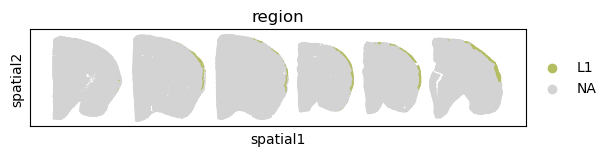

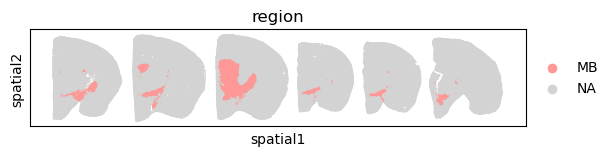

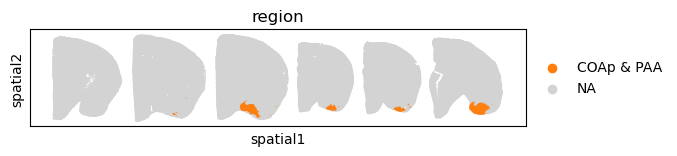

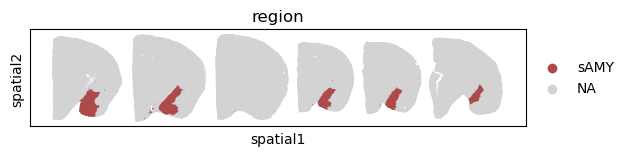

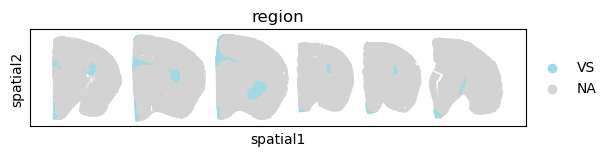

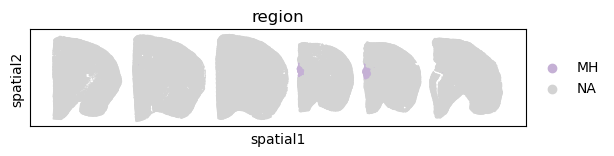

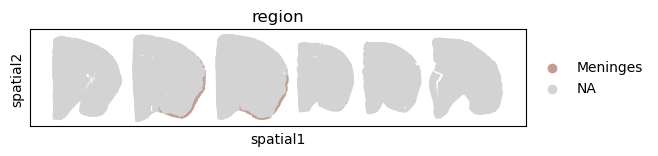

In [80]:
for region in adata.obs['region'].unique():
    sc.pl.spatial(adata,color = 'region',spot_size = 100,groups=region)

In [ ]:
# def check_unique_region_for_clustering(adata, clustering_column, region_column='region'):  
#     result = {}
#     for cluster in adata.obs[clustering_column].unique():
#         regions = adata.obs[adata.obs[clustering_column] == cluster][region_column].unique()
#         if len(regions) == 1: 
#             result[cluster] = regions[0] 
#         else:
#             result[cluster] = None  
    
#     return result

# clustering_columns = ['leiden', 'res_0.8', 'res_1', 'res_1.2', 'res_1.5', 'res_2']
# clustering_results = {}

# for clustering_column in clustering_columns:
#     clustering_results[clustering_column] = check_unique_region_for_clustering(adata, clustering_column)

# for clustering_column, result in clustering_results.items():
#     print(f"Clustering: {clustering_column}")
#     for cluster, region in result.items():
#         if region is not None:
#             print(f"  Cluster {cluster} corresponds to unique region: {region}")
#         else:
#             print(f"  Cluster {cluster} corresponds to multiple regions or none")
#     print("\n")


In [65]:
adata=adata[~adata.obs['region'].isin(['unknown'])]

# sFig2 C

In [66]:
adata.obs['region'] = pd.Categorical(adata.obs['region'], categories=['CA', 'DG', 'L1','L2/3','L4','L5','L6', 'COAp & PAA','FT','HY','MB','PIR','VS','CP','CTXsp','MH','sAMY','TH'] ,ordered=True)

/tmp/ipykernel_3199399/889352008.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['region'] = pd.Categorical(adata.obs['region'], categories=['CA', 'DG', 'L1','L2/3','L4','L5','L6', 'COAp & PAA','FT','HY','MB','PIR','VS','CP','CTXsp','MH','sAMY','TH'] ,ordered=True)


In [67]:
sc.pp.scale(adata)

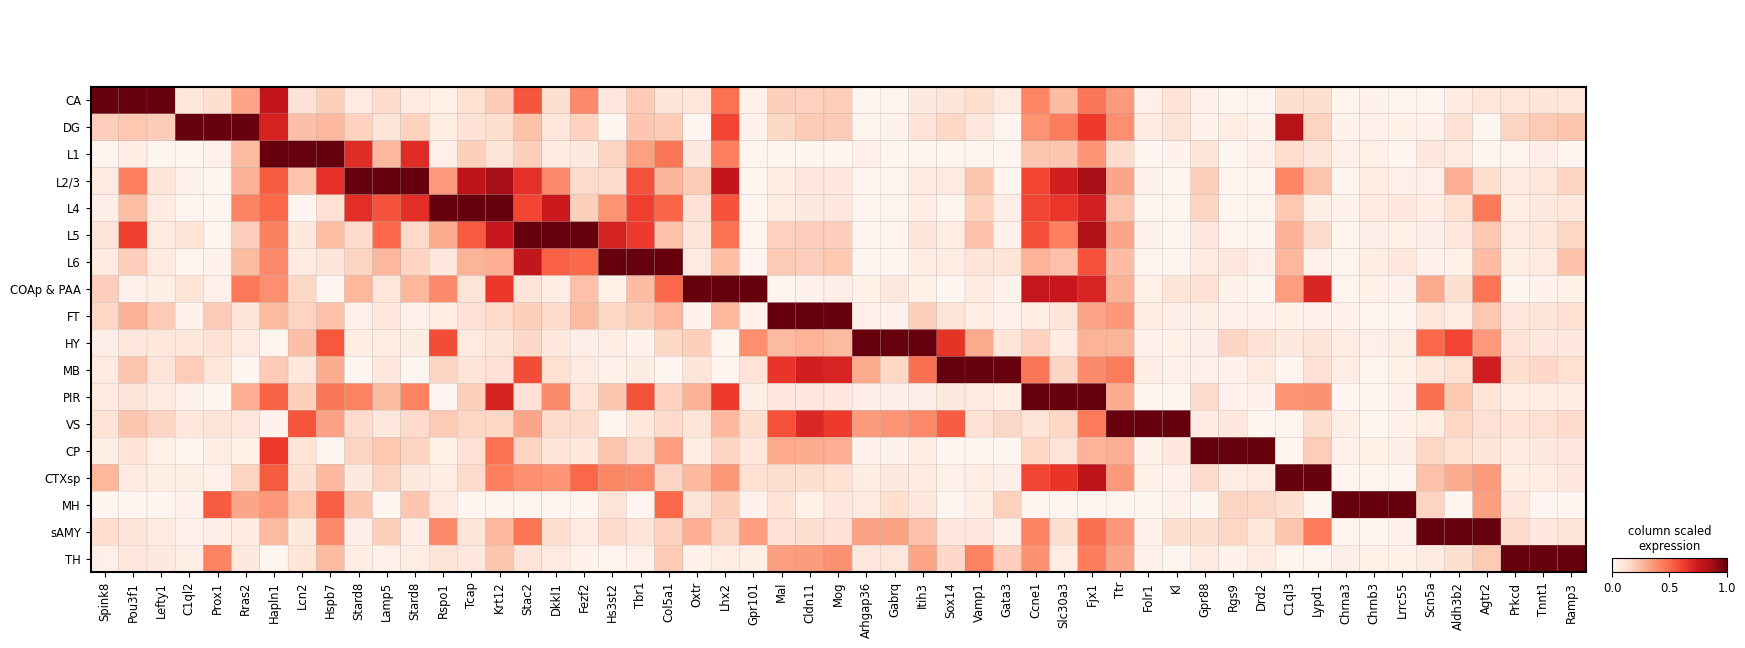

In [68]:
genes = ['Spink8','Pou3f1','Lefty1',
'C1ql2','Prox1','Rras2',
'Hapln1','Lcn2','Hspb7',
'Stard8','Lamp5','Stard8',
'Rspo1','Tcap','Krt12',
'Stac2','Dkkl1','Fezf2',
'Hs3st2','Tbr1','Col5a1',
'Oxtr','Lhx2','Gpr101',
'Mal','Cldn11','Mog',
'Arhgap36','Gabrq','Itih3',
'Sox14','Vamp1','Gata3',
'Ccne1','Slc30a3','Fjx1',
'Ttr','Folr1','Kl',
'Gpr88','Rgs9','Drd2',
'C1ql3','Lypd1',
'Chrna3','Chrnb3','Lrrc55',
'Scn5a','Aldh3b2','Agtr2',
'Prkcd','Tnnt1','Ramp3']

sc.pl.matrixplot(adata, genes, groupby='region',dendrogram=False,
                 cmap='Reds', standard_scale='var', colorbar_title='column scaled\nexpression')

# sFig3 D/F

## MERFISH in situ cell types similar to Stereo-seq V2

In [81]:
adata1=sc.read_h5ad('/home/lixinxing/V2/diffusion/MERFISH/merfish_v2.h5ad')
adata1

AnnData object with n_obs × n_vars = 23148 × 1122
    obs: 'brain_section_label_left', 'brain_section_label_cell_label', 'feature_matrix_label_left', 'donor_label_left', 'donor_genotype_left', 'donor_sex_left', 'cluster_alias_left', 'x_left', 'y_left', 'z_left', 'subclass_confidence_score_left', 'cluster_confidence_score_left', 'high_quality_transfer_left', 'cell_label', 'brain_section_label_right', 'feature_matrix_label_right', 'donor_label_right', 'donor_genotype_right', 'donor_sex_right', 'cluster_alias_right', 'x_right', 'y_right', 'z_right', 'subclass_confidence_score_right', 'cluster_confidence_score_right', 'high_quality_transfer_right', 'cluster_annotation_term_label', 'cluster_annotation_term_set_label', 'cluster_annotation_term_name', 'cluster_annotation_term_set_name', 'number_of_cells', 'color_hex_triplet'
    var: 'gene_symbol'
    uns: 'cluster_annotation_term_name_colors', 'color_hex_triplet_colors'
    obsm: 'spatial', 'spatial_2'

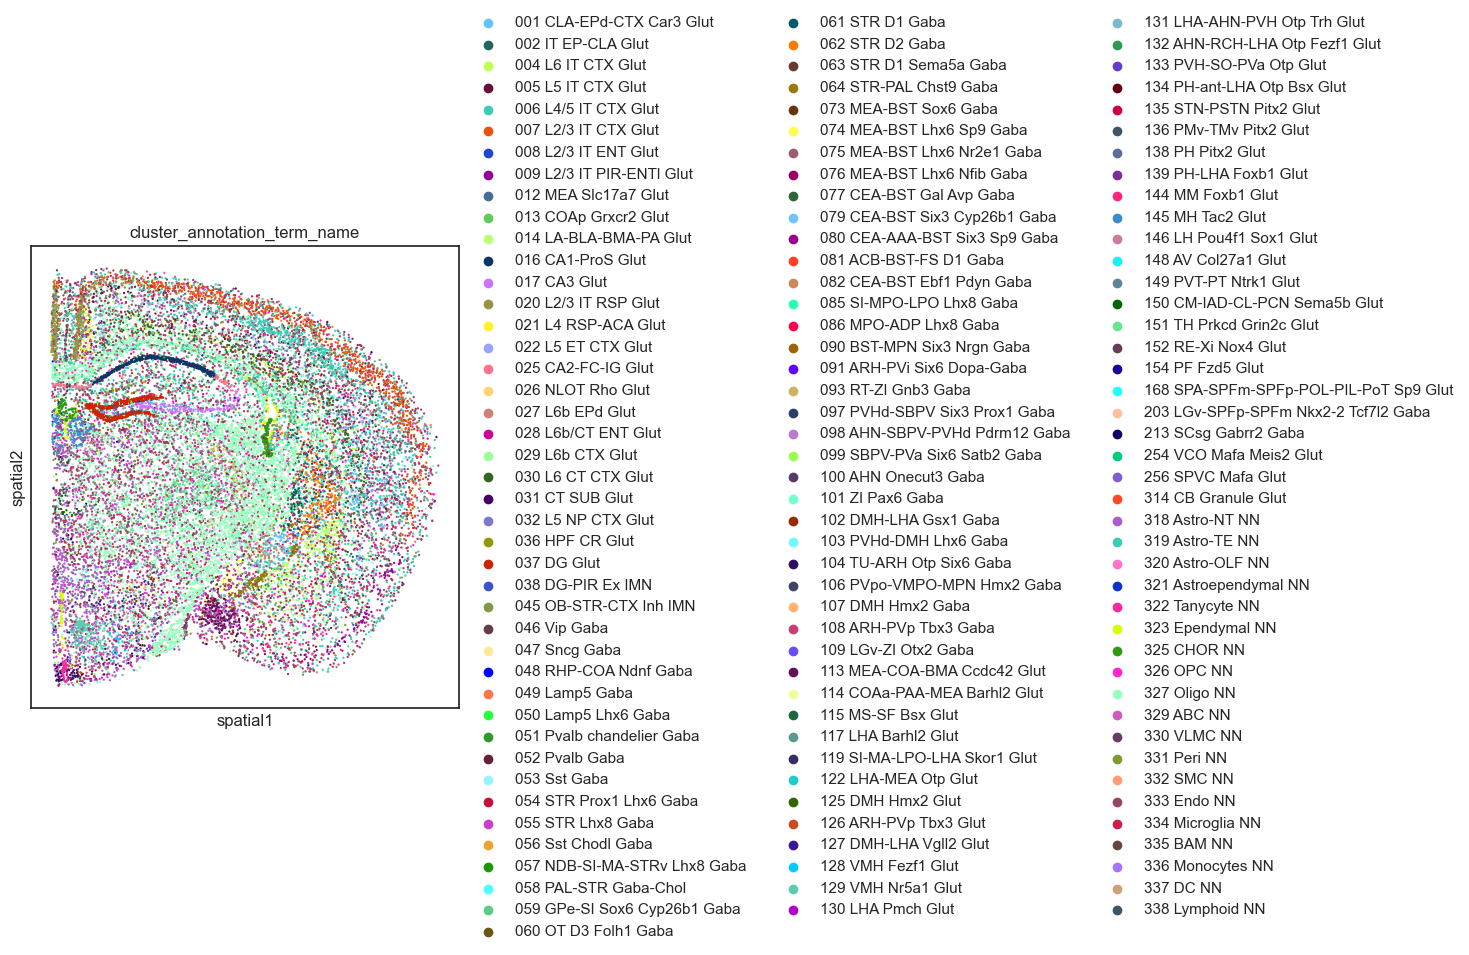

In [197]:
palette = dict(zip(adata1.obs['cluster_annotation_term_name'], 
                   adata1.obs['color_hex_triplet']))


fig,ax=plt.subplots(figsize=(6,6))
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

sc.pl.spatial(adata1, basis='spatial', color='cluster_annotation_term_name',ax=ax,
              palette=palette, spot_size=0.03)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
ax.set_facecolor('white')

#fig.savefig('./MERFISH.pdf')
plt.show()

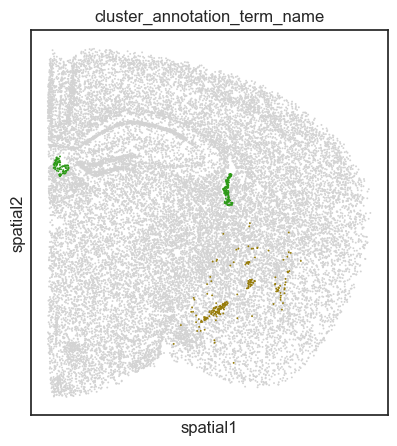

In [204]:
fig,ax=plt.subplots(figsize=(5,5))
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

sc.pl.spatial(adata1, basis='spatial', color=['cluster_annotation_term_name'],groups=['325 CHOR NN','064 STR-PAL Chst9 Gaba'],ax=ax,
              spot_size=0.03,legend_loc=None)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
ax.set_facecolor('white')

# fig.savefig('./celltype/MERFISH_v2_vl.pdf')
plt.show()

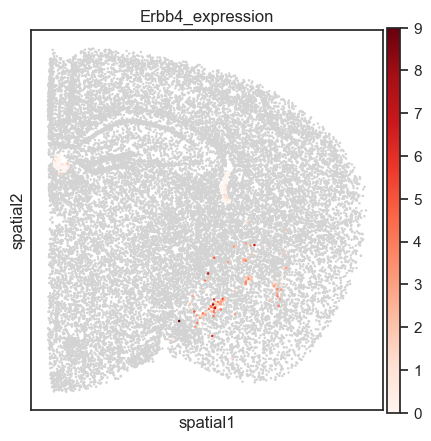

In [206]:
import scanpy as sc
import numpy as np

adata = adata1.copy()
adata.obs['Erbb4_expression'] = adata[:, 'Erbb4'].X.toarray().flatten()
interest_annotations = ['325 CHOR NN','064 STR-PAL Chst9 Gaba']
adata.obs.loc[~adata.obs['cluster_annotation_term_name'].isin(interest_annotations), 'Erbb4_expression'] = np.nan

fig,ax=plt.subplots(figsize=(5,5))
sc.pl.spatial(adata, color='Erbb4_expression', basis='spatial', spot_size=0.04,ax=ax,cmap='Reds',alpha_img=0)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
ax.set_facecolor('white')

# fig.savefig('./celltype/MERFISH_v2_vl_Erbb4.pdf')
plt.show()

## MERFISH in situ cell types similar to Visium FFPE

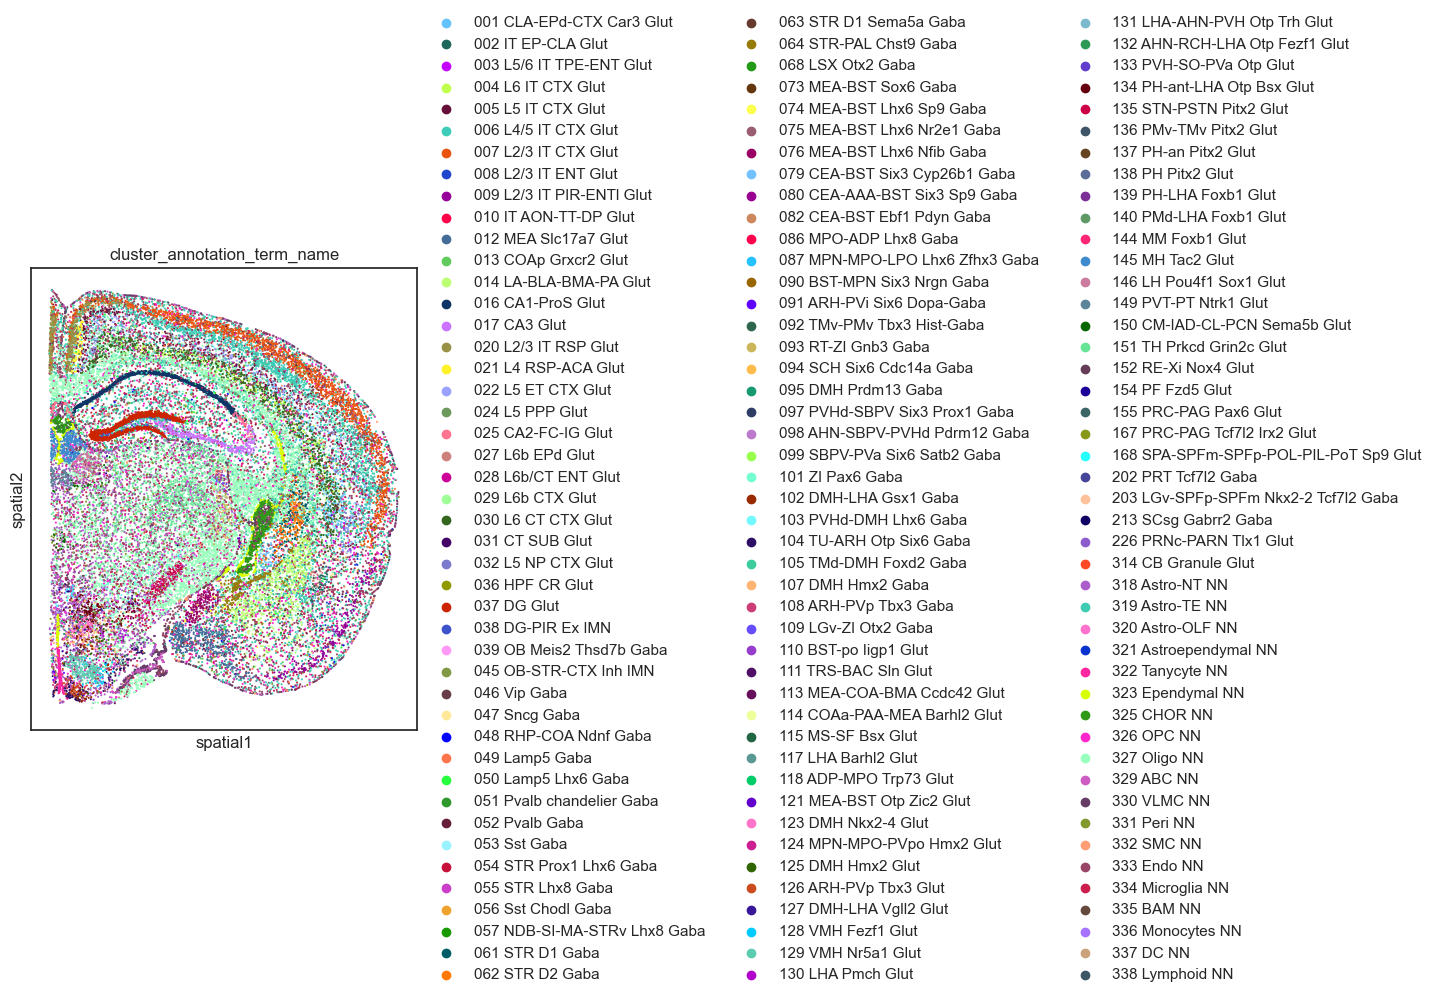

In [198]:
merfish_visium=sc.read_h5ad('/home/lixinxing/V2/diffusion/MERFISH/merfish_ffpe.h5ad')

palette = dict(zip(merfish_visium.obs['cluster_annotation_term_name'], 
                   merfish_visium.obs['color_hex_triplet']))


fig,ax=plt.subplots(figsize=(6,6))
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

sc.pl.spatial(merfish_visium, basis='spatial', color='cluster_annotation_term_name',ax=ax,
              palette=palette, spot_size=0.03)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
ax.set_facecolor('white')

#fig.savefig('./MERFISH.pdf')
plt.show()

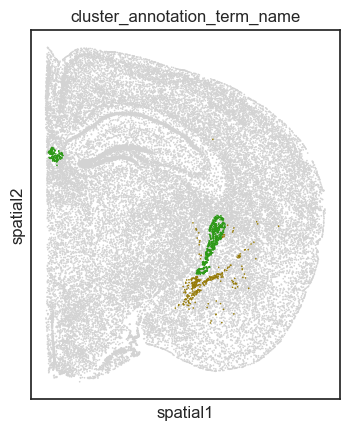

In [207]:
sc.pl.spatial(merfish_visium, basis='spatial', color=['cluster_annotation_term_name'],groups=['325 CHOR NN','064 STR-PAL Chst9 Gaba'],
              spot_size=0.03,legend_loc=None,cmap='Reds',vmax='p99')

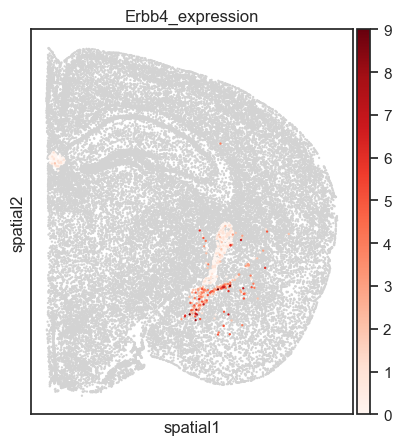

In [208]:
import scanpy as sc
import numpy as np

adata = merfish_visium.copy()
adata.obs['Erbb4_expression'] = adata[:, 'Erbb4'].X.toarray().flatten()
interest_annotations = ['325 CHOR NN','064 STR-PAL Chst9 Gaba']
adata.obs.loc[~adata.obs['cluster_annotation_term_name'].isin(interest_annotations), 'Erbb4_expression'] = np.nan

fig,ax=plt.subplots(figsize=(5,5))
sc.pl.spatial(adata, color='Erbb4_expression', basis='spatial', spot_size=0.04,ax=ax,cmap='Reds',alpha_img=0)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
ax.set_facecolor('white')

# fig.savefig('./celltype/MERFISH_v2_vl_Erbb4.pdf')
plt.show()

# sFig3 E

### Calculate the correlation between Stereo-seq V2 and MERFISH

In [81]:
adata1=sc.read_h5ad('/home/lixinxing/V2/diffusion/MERFISH/merfish_v2.h5ad')
sc.pp.normalize_total(adata1,target_sum=1e3)
sc.pp.log1p(adata1)
adata1

AnnData object with n_obs × n_vars = 23148 × 1122
    obs: 'brain_section_label_left', 'brain_section_label_cell_label', 'feature_matrix_label_left', 'donor_label_left', 'donor_genotype_left', 'donor_sex_left', 'cluster_alias_left', 'x_left', 'y_left', 'z_left', 'subclass_confidence_score_left', 'cluster_confidence_score_left', 'high_quality_transfer_left', 'cell_label', 'brain_section_label_right', 'feature_matrix_label_right', 'donor_label_right', 'donor_genotype_right', 'donor_sex_right', 'cluster_alias_right', 'x_right', 'y_right', 'z_right', 'subclass_confidence_score_right', 'cluster_confidence_score_right', 'high_quality_transfer_right', 'cluster_annotation_term_label', 'cluster_annotation_term_set_label', 'cluster_annotation_term_name', 'cluster_annotation_term_set_name', 'number_of_cells', 'color_hex_triplet'
    var: 'gene_symbol'
    uns: 'cluster_annotation_term_name_colors', 'color_hex_triplet_colors'
    obsm: 'spatial', 'spatial_2'

/home/lixinxing/anaconda3/envs/immune/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/lixinxing/anaconda3/envs/immune/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


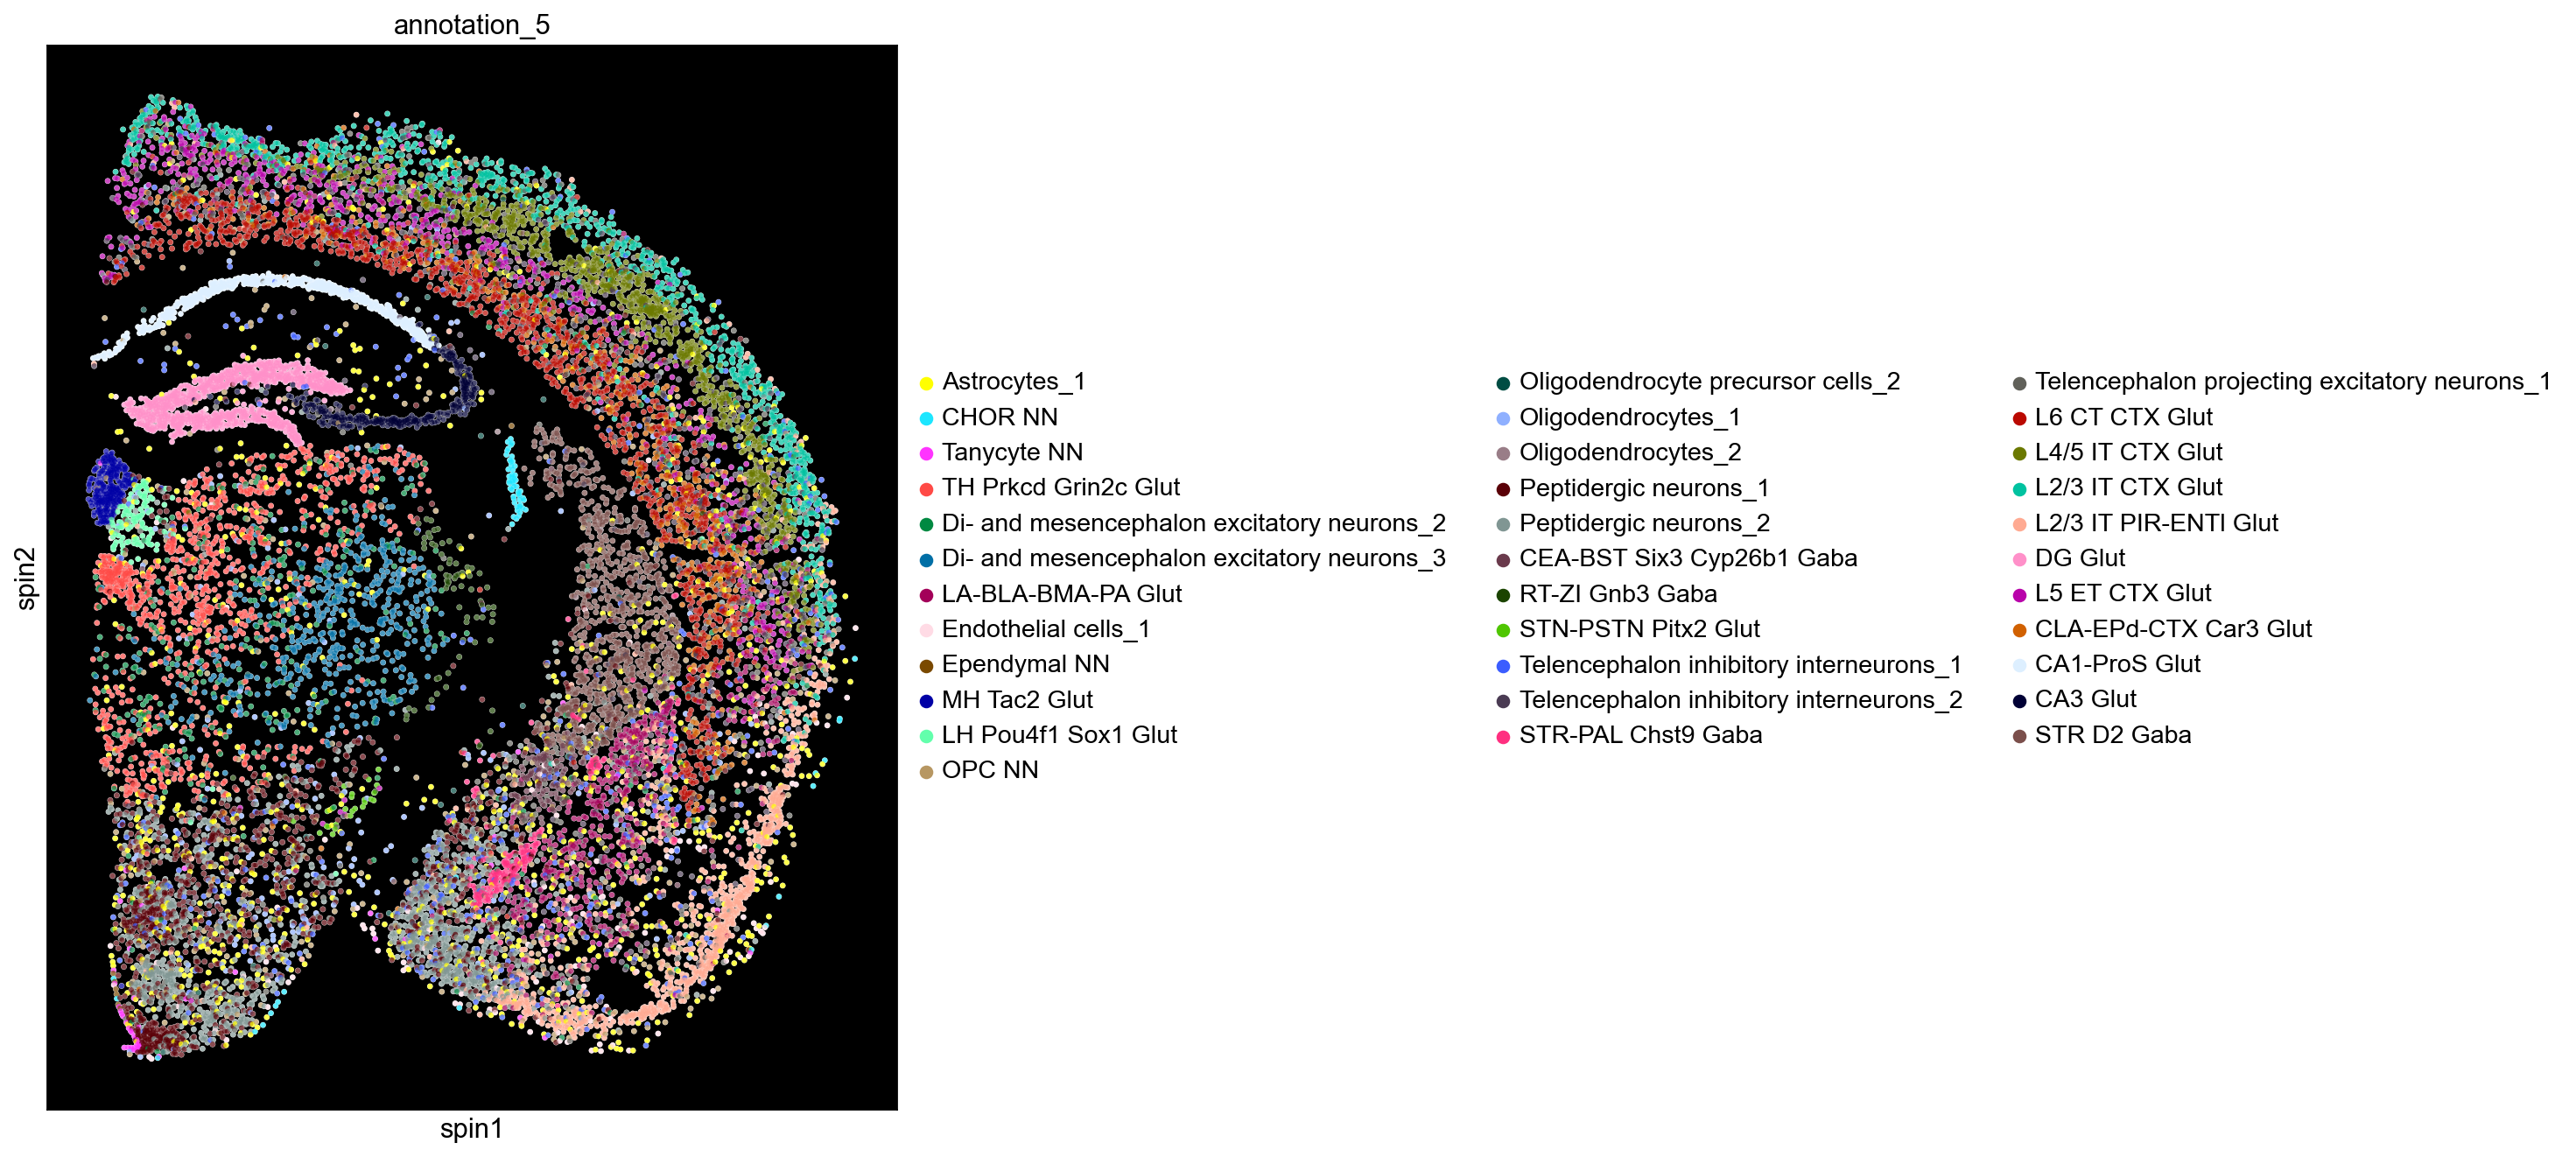

In [92]:
v2=sc.read_h5ad('/home/lixinxing/V2/diffusion/celltype/v2_fig.h5ad')

fig,ax=plt.subplots(figsize=(10,10))
ax.set_facecolor('black')
sc.pl.spatial(v2, basis='spin', color=['annotation_5'], spot_size=60, ax=ax,add_outline=True,edges_color='white')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
ax.set_facecolor('black')
#fig.savefig('./annotation_C4.pdf')
plt.show()

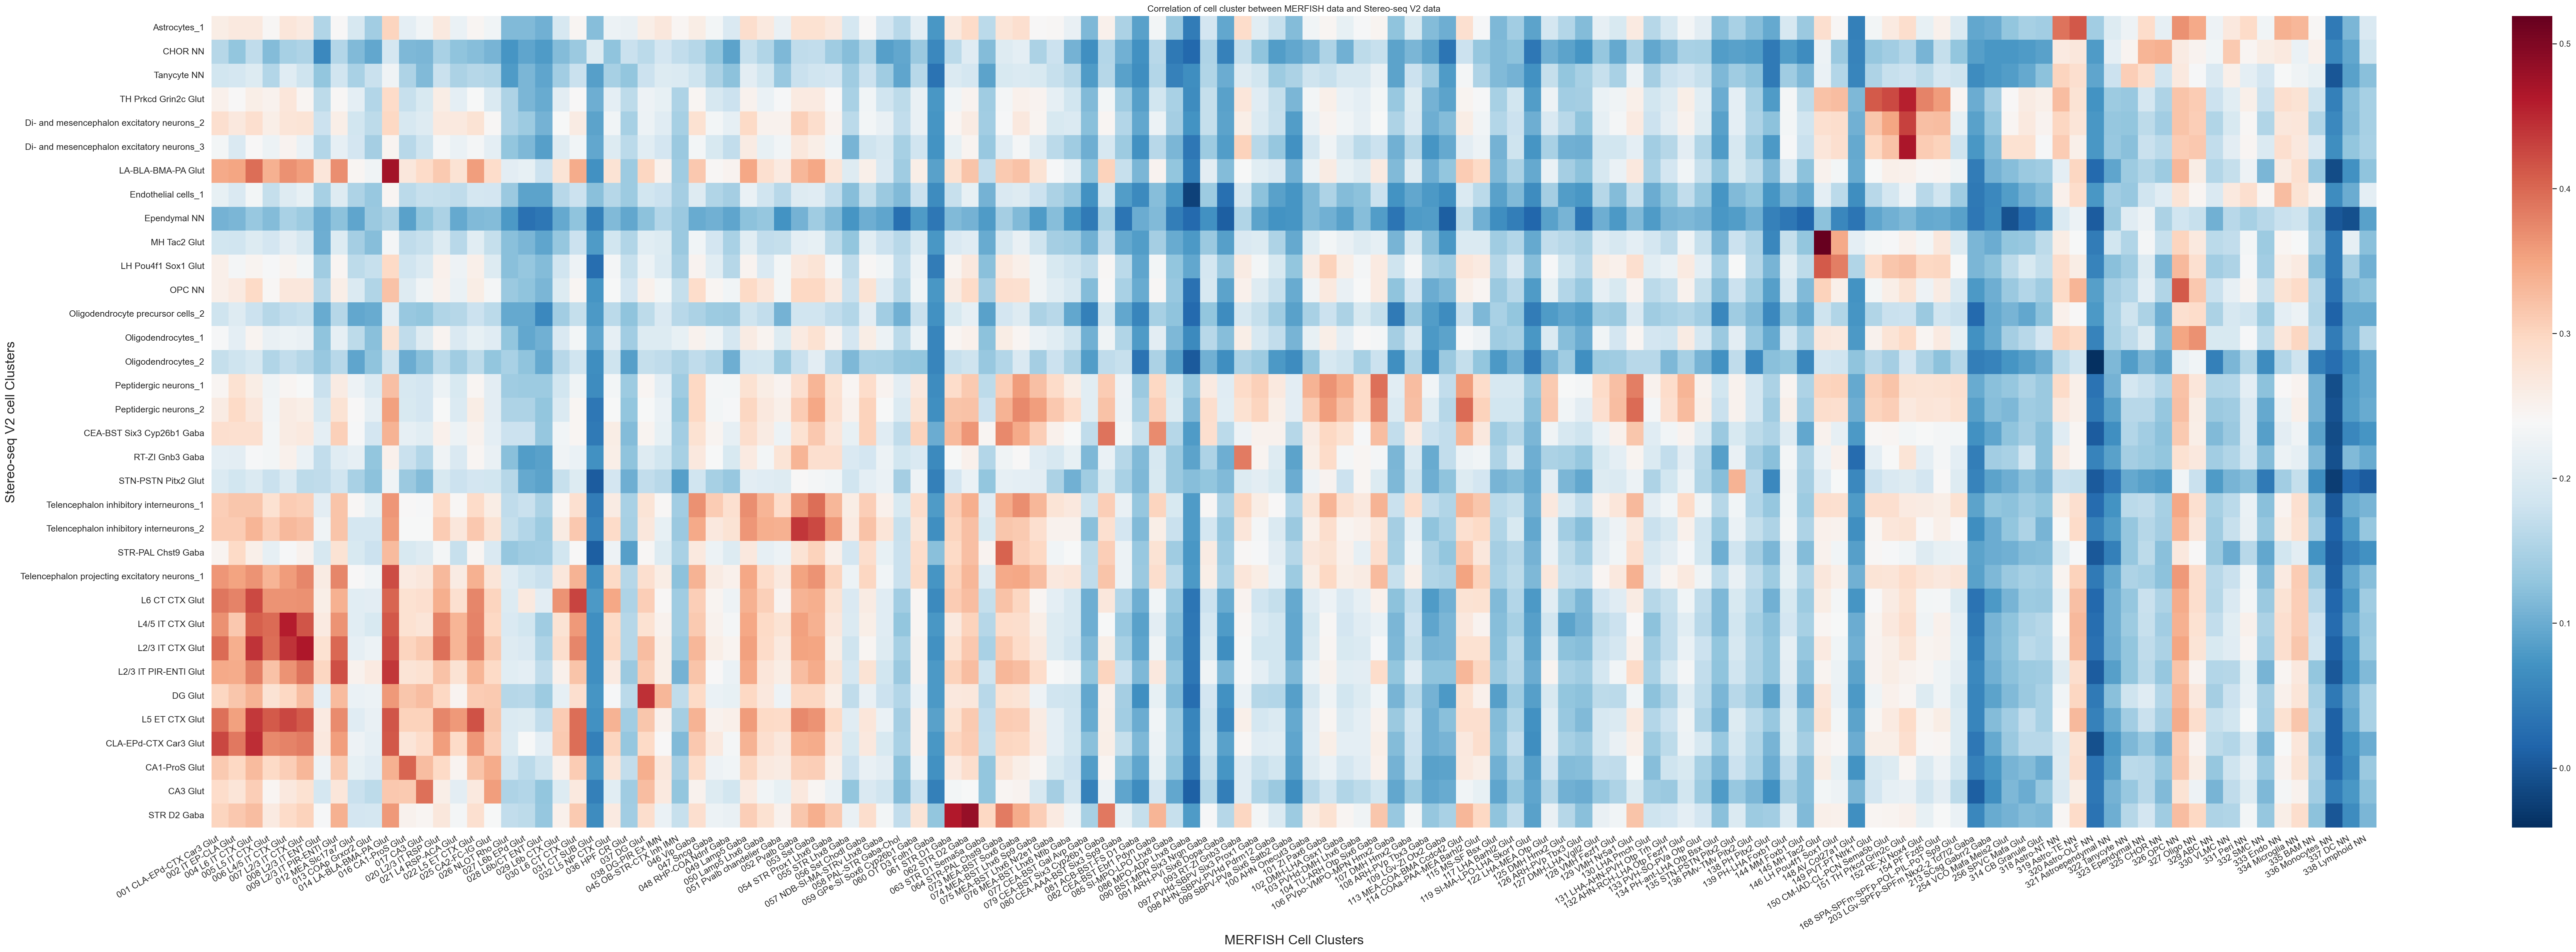

In [104]:
adata2 = new_adata
common_genes = adata1.var_names.intersection(adata2.var_names)
adata1 = adata1[:, common_genes].copy()
adata2 = adata2[:, common_genes].copy()

adata1_expression = adata1.X.toarray() if issparse(adata1.X) else adata1.X
adata2_expression = adata2.X.toarray() if issparse(adata2.X) else adata2.X

adata1_grouped = adata1.obs.groupby('cluster_annotation_term_name')
adata1_sums = {group: adata1_expression[indices].sum(axis=0) for group, indices in adata1_grouped.indices.items()}
adata1_sums_df = pd.DataFrame(adata1_sums, index=common_genes).T

adata2_grouped = adata2.obs.groupby('annotation_5')
adata2_sums = {group: adata2_expression[indices].sum(axis=0) for group, indices in adata2_grouped.indices.items()}
adata2_sums_df = pd.DataFrame(adata2_sums, index=common_genes).T

correlations_spearman = pd.DataFrame(index=adata2_sums_df.index, columns=adata1_sums_df.index)

for adata2_group in adata2_sums_df.index:
    for adata1_group in adata1_sums_df.index:
        correlation, _ = spearmanr(adata2_sums_df.loc[adata2_group], adata1_sums_df.loc[adata1_group])
        correlations_spearman.loc[adata2_group, adata1_group] = correlation

correlations_spearman = correlations_spearman.astype(float)

adata2_new_annotations = correlations_spearman.idxmax(axis=1)
adata2.obs['annotation_5'] = adata2.obs['annotation'].map(adata2_new_annotations)

sns.set(style="white")

plt.figure(figsize=(65, 20))
sns.heatmap(correlations_spearman, annot=False, fmt=".2f", cmap='RdBu_r')

plt.title("Correlation of cell cluster between MERFISH data and Stereo-seq V2 data")
plt.xlabel("MERFISH Cell Clusters", fontsize=18)
plt.ylabel("Stereo-seq V2 cell Clusters", fontsize=18)

plt.xticks(rotation=30, fontsize=12,ha='right') 
plt.yticks(fontsize=12) 
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
#plt.savefig('../celltype/tcorrelation.pdf')
plt.show()